In [284]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from imblearn.over_sampling import SMOTE
from IPython.display import Image
from statsmodels.graphics.factorplots import interaction_plot
from patsy import dmatrices

## Reading the Data

In [245]:
income = pd.read_csv("income_data.csv", sep=r'\s*,\s*', engine='python',na_values = '?')
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [246]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Q1
__1. Build visualizations and plots to see how the dependent variable varies with some of the other variables, such as 'education', 'marital-status', 'occupation', etc and study other interrelationships of the variables. Use them to tell a story/stories.__

__Visualizations__

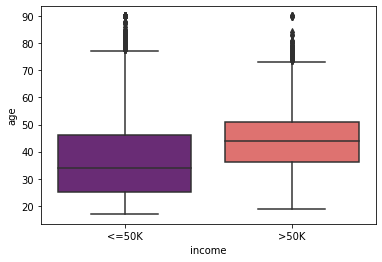

In [247]:
sns.boxplot(y="age", x="income", data=income,palette='magma')

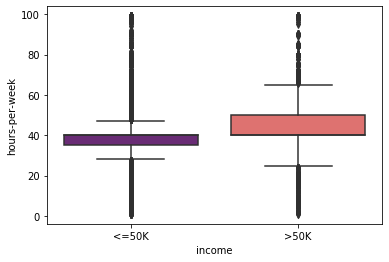

In [248]:
sns.boxplot(y="hours-per-week", x="income", data=income,palette='magma')

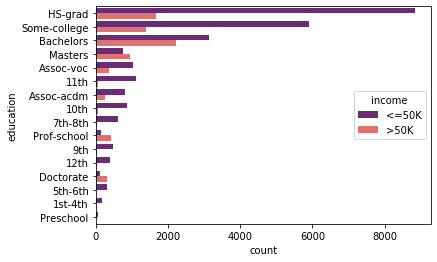

In [249]:
sns.countplot(y='education', hue='income', data = income, order = income['education'].value_counts().index,palette='magma')

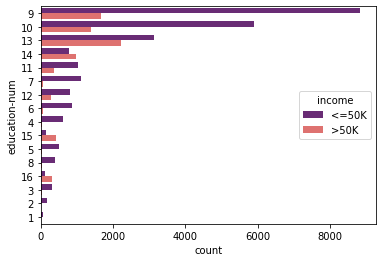

In [250]:
sns.countplot(y='education-num', hue='income', data = income, order = income['education-num'].value_counts().index,palette='magma')

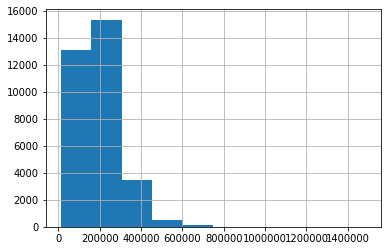

In [251]:
income['fnlwgt'].hist()

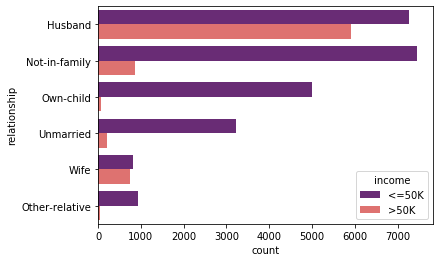

In [252]:
sns.countplot(y='relationship', hue='income', data = income, order = income['relationship'].value_counts().index,palette='magma')

[Text(0, 0, 'Female'), Text(0, 0, 'Male')]

<Figure size 720x360 with 0 Axes>

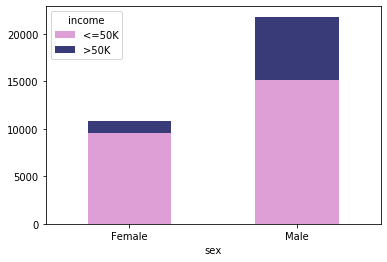

In [253]:
plt.figure(figsize=(10,5))
df_plot = income.groupby(['sex', 'income']).size().reset_index().pivot(columns='income', index='sex', values=0)
chart = df_plot.plot(kind='bar', stacked=True, colormap= 'tab20b_r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)

[Text(0, 0, 'Adm-clerical'),
 Text(0, 0, 'Armed-Forces'),
 Text(0, 0, 'Craft-repair'),
 Text(0, 0, 'Exec-managerial'),
 Text(0, 0, 'Farming-fishing'),
 Text(0, 0, 'Handlers-cleaners'),
 Text(0, 0, 'Machine-op-inspct'),
 Text(0, 0, 'Other-service'),
 Text(0, 0, 'Priv-house-serv'),
 Text(0, 0, 'Prof-specialty'),
 Text(0, 0, 'Protective-serv'),
 Text(0, 0, 'Sales'),
 Text(0, 0, 'Tech-support'),
 Text(0, 0, 'Transport-moving')]

<Figure size 720x360 with 0 Axes>

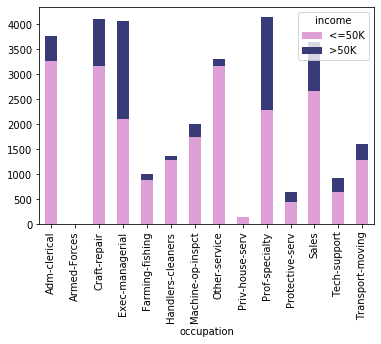

In [254]:
plt.figure(figsize=(10,5))
df_plot = income.groupby(['occupation', 'income']).size().reset_index().pivot(columns='income', index='occupation', values=0)
chart = df_plot.plot(kind='bar', stacked=True, colormap= 'tab20b_r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'Federal-gov'),
 Text(0, 0, 'Local-gov'),
 Text(0, 0, 'Never-worked'),
 Text(0, 0, 'Private'),
 Text(0, 0, 'Self-emp-inc'),
 Text(0, 0, 'Self-emp-not-inc'),
 Text(0, 0, 'State-gov'),
 Text(0, 0, 'Without-pay')]

<Figure size 720x360 with 0 Axes>

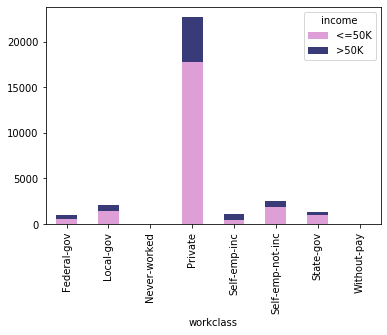

In [255]:
plt.figure(figsize=(10,5))
df_plot = income.groupby(['workclass', 'income']).size().reset_index().pivot(columns='income', index='workclass', values=0)
chart = df_plot.plot(kind='bar', stacked=True, colormap= 'tab20b_r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

__Basic EDA__

In [256]:
factors = ['workclass', 'education', 'marital-status', 'occupation','race', 'sex', 'native-country', 'income']

In [257]:
#droping education num as it is the ordinal representation of education and no new information is captured
#droping fnlwgt as we dont see any patten in this parameter
income = income.drop(['education-num','fnlwgt','relationship'], axis=1)

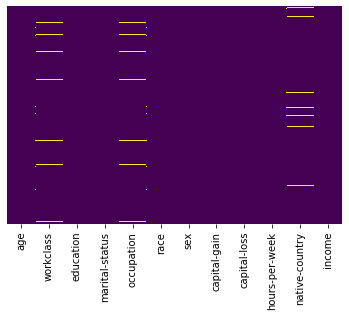

In [258]:
#Checking for nulls
income.isnull().values.any()
sns.heatmap(income.isnull(),yticklabels=False,cbar=False,cmap='viridis')

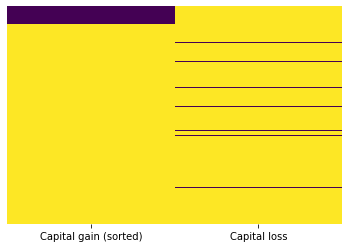

In [259]:
income_Cap=pd.DataFrame()
income_Cap["Capital gain (sorted)"]=income['capital-gain']
income_Cap["Capital loss"]=income['capital-loss']
income_Cap.replace(0, np.nan, inplace=True)
income_Cap=income_Cap.sort_values(by=['Capital gain (sorted)'])
sns.heatmap(income_Cap.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [260]:
#in case nulls need to be handled
for factor in factors:
    income[factor].fillna(value=income[factor].mode()[0], inplace=True)

# Q2
__2. How would you transform your categorical variables and why? Which of them would you transform? If you do not want to transform any, justify why.__

__Transformations__

Variable : education

In [261]:
#merging levels of education
income['education']=np.where(income['education'] =='11th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='9th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='7th-8th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='5th-6th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='10th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='1st-4th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='Preschool', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='12th', 'Not-HS-Grad', income['education'])

Variable: workclass

In [262]:
income['workclass'].value_counts()

Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [263]:
income['workclass']=np.where(income['workclass'] =='Self-emp-not-inc', 'Self Employed', income['workclass'])
income['workclass']=np.where(income['workclass'] =='Local-gov', 'Government', income['workclass'])
income['workclass']=np.where(income['workclass'] =='State-gov', 'Government', income['workclass'])
income['workclass']=np.where(income['workclass'] =='Self-emp-inc', 'Self Employed', income['workclass'])
income['workclass']=np.where(income['workclass'] =='Federal-gov', 'Government', income['workclass'])
income['workclass']=np.where(income['workclass'] =='Without-pay', 'Other', income['workclass'])
income['workclass']=np.where(income['workclass'] =='Never-worked', 'Other', income['workclass'])

Variable: Marital status

In [264]:
income['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

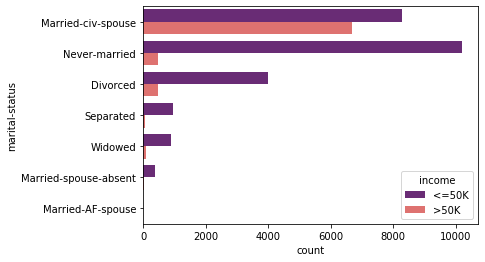

In [265]:
sns.countplot(y='marital-status', hue='income', data = income,order = income['marital-status'].value_counts().index,palette='magma')

In [266]:
income['marital-status']=np.where(income['marital-status'] =='Married-civ-spouse', 'Married', income['marital-status'])
income['marital-status']=np.where(income['marital-status'] =='Married-spouse-absent', 'Married', income['marital-status'])
income['marital-status']=np.where(income['marital-status'] =='Married-AF-spouse', 'Married', income['marital-status'])

Variable: native-country

In [267]:
income['native-country']=np.where(income['native-country'] !='United-States', 'Non-US', income['native-country'])

In [268]:
income['native-country'].value_counts()

United-States    29753
Non-US            2808
Name: native-country, dtype: int64

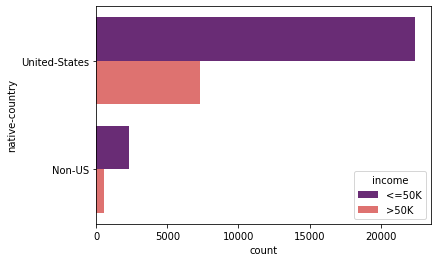

In [269]:
sns.countplot(y="native-country", hue="income", data=income,palette='magma')

Variable: Capital gain and capital loss 

In [270]:
income['Capital_Change']= income['capital-gain']-income['capital-loss']
income = income.drop(['capital-gain','capital-loss'], axis=1)

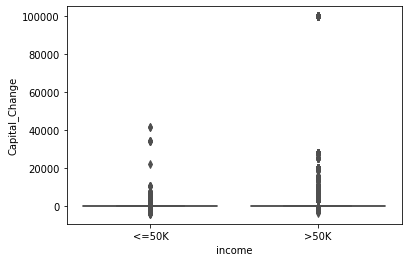

In [271]:
sns.boxplot(y="Capital_Change", x="income", data=income,palette='rainbow')

In [272]:
income.head()

,age,workclass,education,marital-status,occupation,race,sex,hours-per-week,native-country,income,Capital_Change
0,39,Government,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,<=50K,2174
1,50,Self Employed,Bachelors,Married,Exec-managerial,White,Male,13,United-States,<=50K,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,<=50K,0
3,53,Private,Not-HS-Grad,Married,Handlers-cleaners,Black,Male,40,United-States,<=50K,0
4,28,Private,Bachelors,Married,Prof-specialty,Black,Female,40,Non-US,<=50K,0


In [273]:
#assigning levels to the values of categorical variables
income_fact = income.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,education,marital-status,occupation,race,sex,hours-per-week,native-country,income,Capital_Change
0,39,0,2,2,0,4,1,40,1,0,2174
1,50,3,2,1,3,4,1,13,1,0,0
2,38,2,4,0,5,4,1,40,1,0,0
3,53,2,6,1,5,2,1,40,1,0,0
4,28,2,2,1,9,2,0,40,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c490abb70>,
      dtype=object)

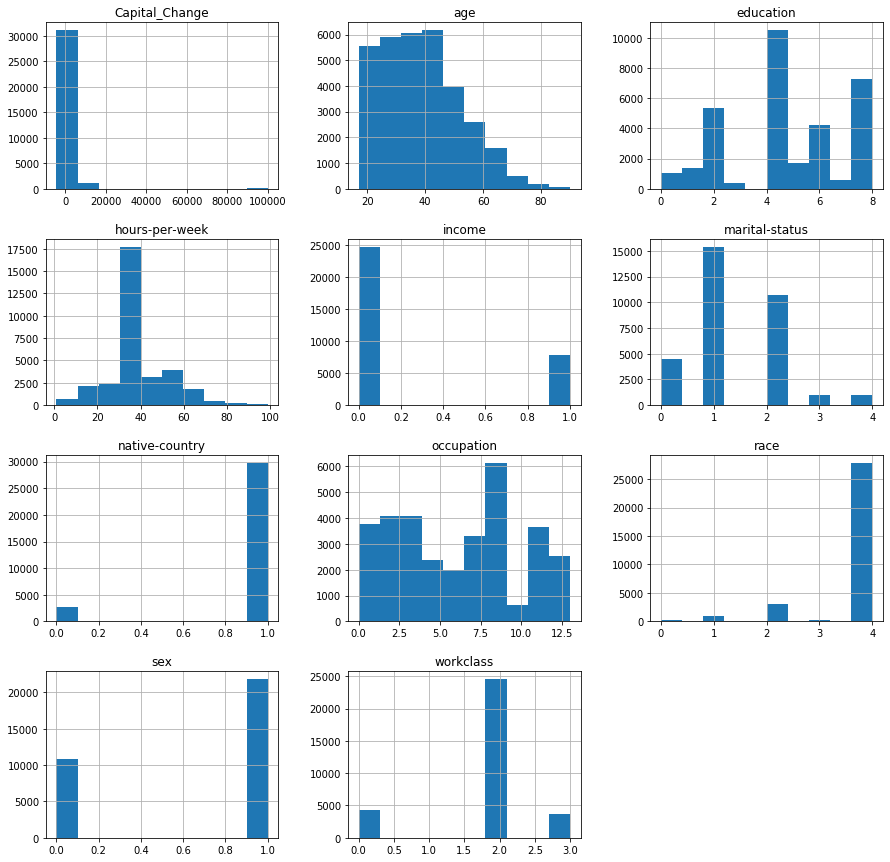

In [274]:
income_fact.hist(figsize=(15,15))

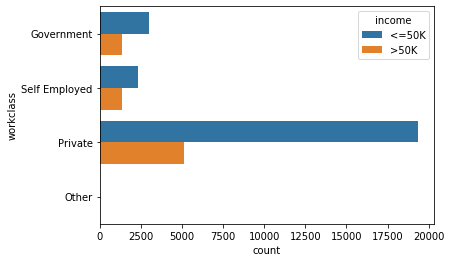

In [275]:
sns.countplot(y='workclass', hue='income', data = income)

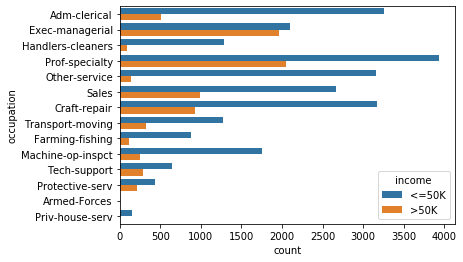

In [276]:
sns.countplot(y='occupation', hue='income', data = income)

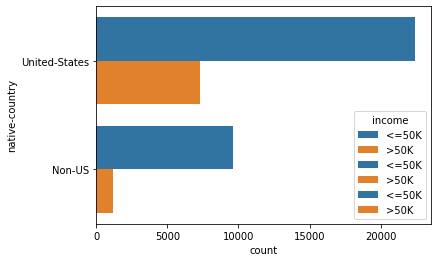

In [277]:
#missingdata visualization:
sns.countplot(y='race', hue='income', data = income)
sns.countplot(y='sex', hue='income', data = income)
sns.countplot(y='native-country', hue='income', data = income)

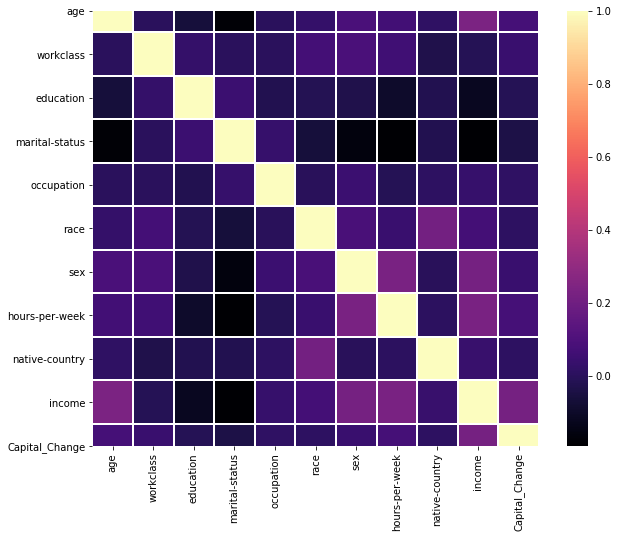

In [278]:
#correlation matrix of the data
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(income_fact.corr(),cmap='magma', linecolor='white',linewidths=1)

#There does not seem to be a strong observable correlation in this 

In [279]:
#checking for class imbalance
print(income['income'].value_counts())
print(str(round(income['income'].value_counts()[1]*100/income.shape[0],2)) + '%')

#We can see a clear imbalance

<=50K    24720
>50K      7841
Name: income, dtype: int64
24.08%


Text(0, 0.5, 'High Salary')

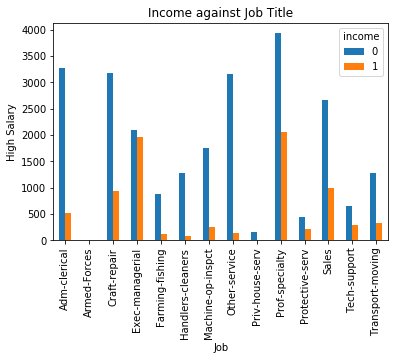

In [280]:
#determining if a variable is good predictor of income through plots
%matplotlib inline
pd.crosstab(income['occupation'],income_fact['income']).plot(kind='bar')
plt.title('Income against Job Title')
plt.xlabel('Job')
plt.ylabel('High Salary')

# Q3 & Q4
__3. Use a technique of your choice to eliminate some of the features. Explain your method.__

__4. Fit a regression model to predict whether income of an individual is more than 50k. What
regression model do you use? Why? How well is your model performing?__

__Creating Dummy Variables__

In [281]:
income_copy = income.copy()
for var in factors:
    if var != 'income':
        print
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_copy[var], prefix=var, drop_first = True)
        income_copy = pd.concat([income_copy,cat_list], axis = 1)#removing the base coloumn to account for multicollinearity problem
        income_copy = income_copy.drop(var, 1)
income_copy.head()

,age,hours-per-week,income,Capital_Change,workclass_Other,workclass_Private,workclass_Self Employed,education_Assoc-voc,education_Bachelors,education_Doctorate,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_United-States
0,39,40,<=50K,2174,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
1,50,13,<=50K,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,38,40,<=50K,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,53,40,<=50K,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,28,40,<=50K,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


__Use Logistic Regression with all variables to predict__

In [282]:
#70% records being sent into training set 
income_copy['income'] = income_copy['income'].factorize()[0]
pts = np.random.rand(len(income_copy)) < 0.7

income_train = income_copy[pts]
income_test = income_copy[~pts]

X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

#fitting the model
lr1 = LogisticRegression(max_iter = 1000)
lr1.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [285]:
#generating confusion matrix
X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']
Y_pred = lr1.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
c = classification_report(Y_test, Y_pred)
print(confusion_matrix)
print(c)

[[6874  506]
 [1035 1287]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7380
           1       0.72      0.55      0.63      2322

    accuracy                           0.84      9702
   macro avg       0.79      0.74      0.76      9702
weighted avg       0.83      0.84      0.83      9702



In [286]:
from sklearn.metrics import roc_curve, auc
def draw_ROC_curve(y_test, X_test, title):
    '''
    Draw ROC curve
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, lr1.predict_proba(X_test)[:,1])
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title(title)
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc, color = 'purple')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()
    plt.close(0)

ROC for original model

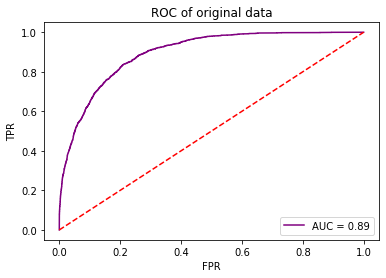

In [288]:
draw_ROC_curve(Y_test,X_test, 'ROC of original data')

__Accounting for oversampling__

In [289]:
from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state = 2) 
X_train_res, y_train_res = smote.fit_sample(X_train, Y_train.ravel()) 

In [290]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, counts of label '1': 17340
After OverSampling, counts of label '0': 17340


In [291]:
lr1 = LogisticRegression(max_iter = 1000) 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(Y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      7380
           1       0.60      0.74      0.66      2322

    accuracy                           0.82      9702
   macro avg       0.75      0.79      0.77      9702
weighted avg       0.84      0.82      0.82      9702



ROC for oversampled model

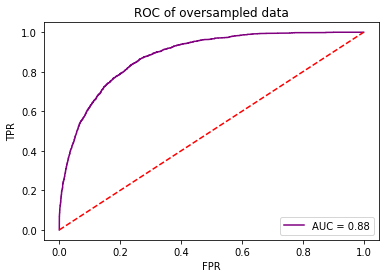

In [292]:
draw_ROC_curve(Y_test, X_test, 'ROC of oversampled data')

__Feature selection by Decision Tree__

In [293]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [294]:
pd_dict = {'Features': X_train.columns, 'Importance': clf.feature_importances_}
feature = pd.DataFrame(pd_dict)
importance = feature.sort_values('Importance', ascending = False)
nodes = importance[importance['Importance'] != 0]
nodes

,Features,Importance
14,marital-status_Married,0.548966
2,Capital_Change,0.141728
11,education_Not-HS-Grad,0.114377
9,education_HS-grad,0.105720
15,marital-status_Never-married,0.088065
0,age,0.001144


__The variables we obtain__

In [295]:
factors = ['marital-status', 'Capital_Change', 'education', 'age', 'income']

In [296]:
income_red = income.copy()
income_red = income_red[factors]
for var in factors:
    if var != 'income':
        print
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_red[var], prefix=var, drop_first = True)
        income_red = pd.concat([income_red,cat_list], axis = 1)#removing the base coloumn to account for multicollinearity problem
        income_red = income_red.drop(var, 1)
income_red.head()

,income,marital-status_Married,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,Capital_Change_-3900,Capital_Change_-3770,Capital_Change_-3683,Capital_Change_-3004,Capital_Change_-2824,...,age_80,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_90
0,<=50K,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,<=50K,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,<=50K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,<=50K,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,<=50K,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Run logistic regression again on four selected variables__

In [297]:
#70% records being sent into training set 
income_red['income'] = income_red['income'].factorize()[0]
pts = np.random.rand(len(income_red)) < 0.7

income_train = income_red[pts]
income_test = income_red[~pts]

X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']

X_train_res_red, y_train_res_red = smote.fit_sample(X_train, Y_train.ravel()) 

lr1 = LogisticRegression(max_iter = 1000) 
lr1.fit(X_train_res_red, y_train_res_red.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(Y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      7553
           1       0.57      0.82      0.67      2291

    accuracy                           0.81      9844
   macro avg       0.75      0.82      0.77      9844
weighted avg       0.85      0.81      0.82      9844



In [298]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, predictions)

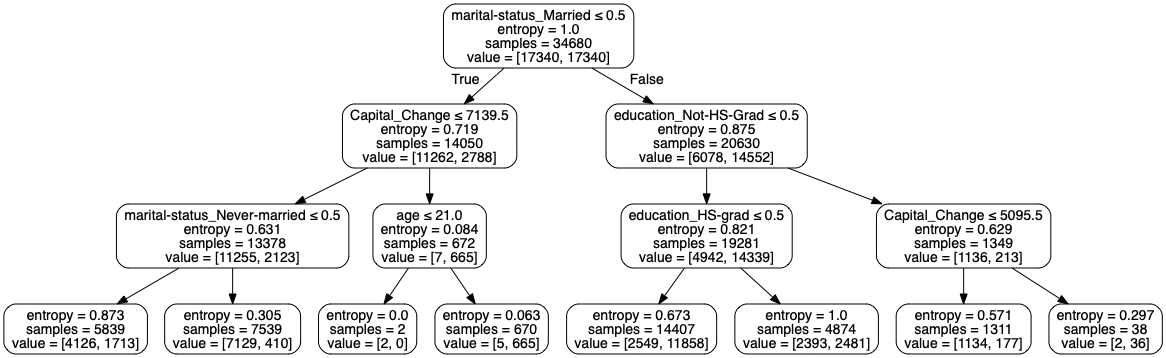

In [299]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                rounded=True,
                special_characters=True,feature_names = X_train_res.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

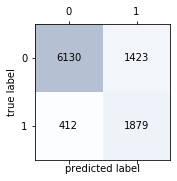

In [300]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

ROC for oversampled model with reduced variables

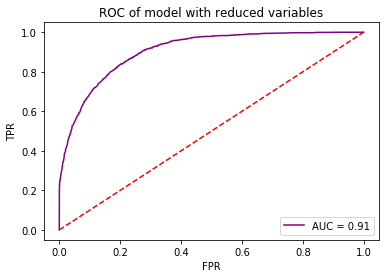

In [301]:
draw_ROC_curve(Y_test, X_test, 'ROC of model with reduced variables')

__Conclusion:__
    
__The ROC curve indicates that after oversampling, logistic regression on variables selected by Desicion Tree performs the best.__

# Q5
__Use the income dataset to regress work hours on the rest of the data. Compare the R^2 with
R^2 of another model that you fit with only the significant variables. Explore some
interaction terms and explain why they were of interest.__

In [212]:
income_workhours = income.copy()
income_workhours.columns = ['age', 'workclass','edu','marital','occupation','race','sex','workhours','native','income','capital']

In [213]:
# add interactions of interest
y,X_part = dmatrices('workhours ~ age + workclass + edu + marital + occupation + race + sex + native + income + capital + age:workclass + sex:edu + native:race + occupation:sex', data = income_workhours, return_type = 'dataframe')
# OLS model
mod_part = sm.OLS(y, X_part)
# fit model
res_part = mod_part.fit()     
# Summarize model
print(res_part.summary2()) 

                                   Results: Ordinary least squares
Model:                         OLS                         Adj. R-squared:                0.172      
Dependent Variable:            workhours                   AIC:                           250002.7666
Date:                          2020-01-16 20:11            BIC:                           250548.1731
No. Observations:              32561                       Log-Likelihood:                -1.2494e+05
Df Model:                      64                          F-statistic:                   106.7      
Df Residuals:                  32496                       Prob (F-statistic):            0.00       
R-squared:                     0.174                       Scale:                         126.23     
-----------------------------------------------------------------------------------------------------
                                                    Coef.   Std.Err.    t     P>|t|   [0.025   0.975]
---------------

In [214]:
# delete insignificant factors
# delete 'native-country', 'race'

# merging insignificant levels together
# 1. look for levels that have similar response rate
## a. workclass
# since the response rate of private is close to government, try to merge these two
income_merge = income_workhours.copy()
income_merge['workclass']=np.where(income_merge['workclass'] =='Government', 'Non Self-Employed', income_merge['workclass'])
income_merge['workclass']=np.where(income_merge['workclass'] =='Private', 'Non Self-Employed', income_merge['workclass'])

In [215]:
## b. edu
income_merge['edu']=np.where(income_merge['edu'] =='HS-grad', 'Under College', income_merge['edu'])
income_merge['edu']=np.where(income_merge['edu'] =='Some-college', 'Under College', income_merge['edu'])
income_merge['edu']=np.where(income_merge['edu'] =='Assoc-voc', 'Under College', income_merge['edu'])
income_merge['edu']=np.where(income_merge['edu'] =='Assoc-acdm', 'Under College', income_merge['edu'])

In [216]:
## c. occupation
income_merge['occupation']=np.where(income_merge['occupation'] =='Armed-Forces', 'Mixed', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Other-service', 'Mixed', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Machine-op-inspct', 'Mixed', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Exec-managerial', 'Intellectual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Sales', 'Intellectual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Tech-support', 'Intellectual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Prof-specialty', 'Intellectual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Protective-serv', 'Manual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Priv-house-serv', 'Manual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Handlers-cleaners', 'Manual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Farming-fishing', 'Manual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Craft-repair', 'Manual', income_merge['occupation'])
income_merge['occupation']=np.where(income_merge['occupation'] =='Transport-moving', 'Manual', income_merge['occupation'])

In [217]:
income_merge.drop(['race', 'native'], 1, inplace = True)

In [218]:
income_merge.head()

,age,workclass,edu,marital,occupation,sex,workhours,income,capital
0,39,Non Self-Employed,Bachelors,Never-married,Adm-clerical,Male,40,<=50K,2174
1,50,Self Employed,Bachelors,Married,Intellectual,Male,13,<=50K,0
2,38,Non Self-Employed,Under College,Divorced,Manual,Male,40,<=50K,0
3,53,Non Self-Employed,Not-HS-Grad,Married,Manual,Male,40,<=50K,0
4,28,Non Self-Employed,Bachelors,Married,Intellectual,Female,40,<=50K,0


In [219]:
# regress again
y,X_part = dmatrices('workhours ~ age + workclass + edu + marital + occupation + income + capital + age:workclass + sex:edu + occupation:sex', data=income_merge, return_type='dataframe')
# OLS model
mod_part = sm.OLS(y, X_part)
# fit model
res_part = mod_part.fit()     
# Summarize model
print(res_part.summary2()) 

                             Results: Ordinary least squares
Model:                     OLS                     Adj. R-squared:            0.144      
Dependent Variable:        workhours               AIC:                       251033.3946
Date:                      2020-01-16 20:11        BIC:                       251276.7298
No. Observations:          32561                   Log-Likelihood:            -1.2549e+05
Df Model:                  28                      F-statistic:               197.4      
Df Residuals:              32532                   Prob (F-statistic):        0.00       
R-squared:                 0.145                   Scale:                     130.43     
-----------------------------------------------------------------------------------------
                                        Coef.   Std.Err.    t     P>|t|   [0.025   0.975]
-----------------------------------------------------------------------------------------
Intercept                              

In [220]:
sex = list(income_merge['sex'])
edu = list(income_merge['edu'])
occupation = list(income_merge['occupation'])
age = list(income_merge['age'])
workclass = list(income_merge['workclass'])
hours = list(income_merge['workhours'])

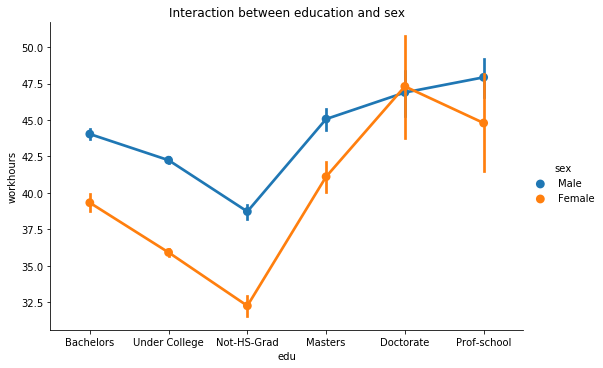

In [221]:
sns.catplot(x = 'edu', y = 'workhours', hue = 'sex', kind = 'point', data = income_merge, height=5, aspect=1.5)
plt.title('Interaction between education and sex')
plt.show()

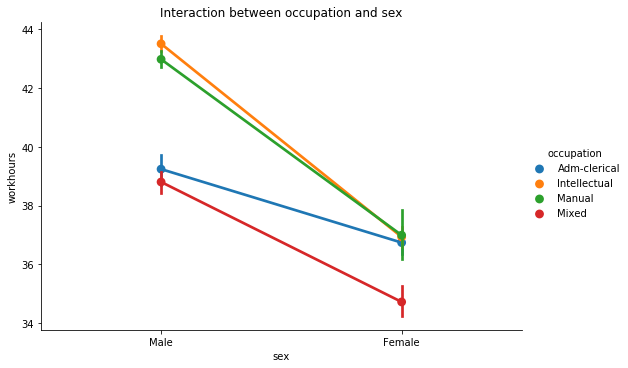

In [222]:
sns.catplot(x = 'sex', y = 'workhours', hue = 'occupation', kind = 'point', data = income_merge, height=5, aspect=1.5)
plt.title('Interaction between occupation and sex')
plt.show()

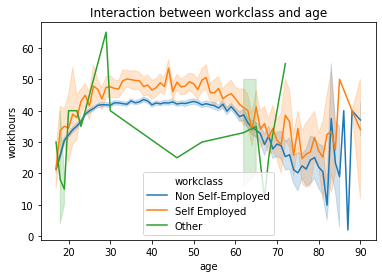

In [223]:
sns.lineplot(x = 'age', y = 'workhours', hue = 'workclass', data = income_merge) 
plt.title('Interaction between workclass and age')
plt.show()

# Q6
__Regress work hours of only people who are working in Sales. Once you fit a reasonable (as
per your judgement) model for this data, compare the R^2 with the ones you calculated for Question 5. Explain your findings.__

In [224]:
income_by_sales = income[income['occupation'] == 'Sales']
income_by_sales.drop('occupation', 1, inplace = True)
income_by_sales = income_by_sales.rename(columns = {'marital-status': 'marital', 'hours-per-week': 'hours', 'native-country': 'native', 'Capital_Change': 'capital'})
income_by_sales.head()

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,age,workclass,education,marital,race,sex,hours,native,income,capital
13,32,Private,Assoc-acdm,Never-married,Black,Male,50,United-States,<=50K,0
18,38,Private,Not-HS-Grad,Married,White,Male,50,United-States,<=50K,0
31,20,Private,Some-college,Never-married,Black,Male,44,United-States,<=50K,0
38,31,Private,Some-college,Married,White,Male,38,United-States,>50K,0
60,30,Private,Bachelors,Married,White,Male,40,United-States,<=50K,2407


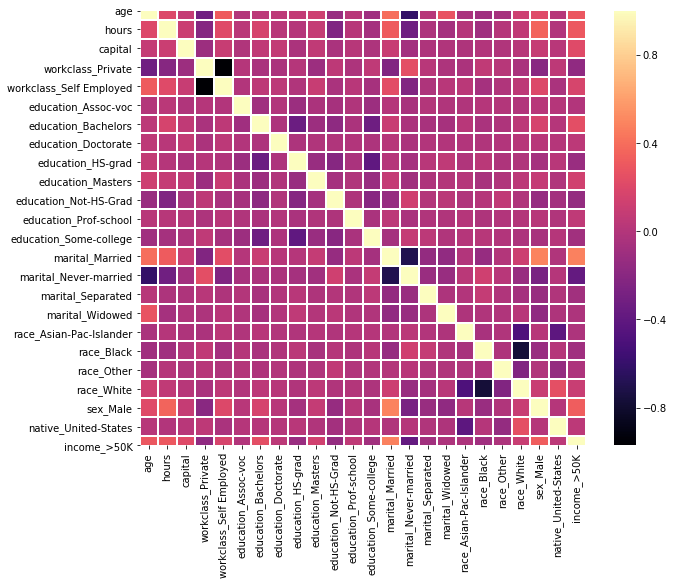

In [225]:
#assigning levels to the values of categorical variables
cat_var = ['workclass', 'education', 'marital', 'race', 'sex', 'native', 'income']
income_fact = income_by_sales.copy()
for var in cat_var:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(income_fact[var], prefix = var, drop_first = True)
    income_fact = pd.concat([income_fact,cat_list], axis = 1)#removing the base coloumn to account for multicollinearity problem
    income_fact = income_fact.drop(var, 1)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(income_fact.corr(),cmap = 'magma', linecolor = 'white',linewidths = 1)

In [226]:
# regress 
y,X_sales = dmatrices('hours ~ age + workclass + education + marital + race + sex + native + income + capital + sex:education + sex:race + native:workclass + age:workclass + income:age + income:sex + income:native', data = income_by_sales, return_type='dataframe')
# OLS model
mod_sales = sm.OLS(y, X_sales)
# fit model
res_sales = mod_sales.fit()     
# Summarize model
print(res_sales.summary2()) 

                                  Results: Ordinary least squares
Model:                          OLS                        Adj. R-squared:               0.265     
Dependent Variable:             hours                      AIC:                          28133.9983
Date:                           2020-01-16 20:11           BIC:                          28400.7050
No. Observations:               3650                       Log-Likelihood:               -14024.   
Df Model:                       42                         F-statistic:                  32.29     
Df Residuals:                   3607                       Prob (F-statistic):           3.52e-215 
R-squared:                      0.273                      Scale:                        128.81    
---------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
----------------------------------

In [227]:
income_by_sales['workclass'] = np.where(income_by_sales['workclass'] =='Government', 'Non Self Employed', income_by_sales['workclass'])
income_by_sales['workclass'] = np.where(income_by_sales['workclass'] =='Private', 'Non Self Employed', income_by_sales['workclass'])

In [228]:
income_by_sales['education'] = np.where(income_by_sales['education'] =='Assoc-voc', 'Others', income_by_sales['education'])
income_by_sales['education'] = np.where(income_by_sales['education'] =='Prof-school', 'Others', income_by_sales['education'])
income_by_sales['education'] = np.where(income_by_sales['education'] =='Doctorate', 'Others', income_by_sales['education'])
income_by_sales['education'] = np.where(income_by_sales['education'] =='Some-college', 'Others', income_by_sales['education'])
income_by_sales['education'] = np.where(income_by_sales['education'] =='Masters', 'Others', income_by_sales['education'])
income_by_sales['education'] = np.where(income_by_sales['education'] =='Prof-school', 'Others', income_by_sales['education'])
income_by_sales['education'] = np.where(income_by_sales['education'] =='Assoc-acdm', 'Others', income_by_sales['education'])

In [229]:
# Delete sex:race, sex:income, income:native, race
# run regression again
y,X_sales = dmatrices('hours ~ age + workclass + education + marital + sex + income + capital + native + sex:education + native:workclass + age:workclass + income:age', data = income_by_sales, return_type='dataframe')
# OLS model
mod_sales = sm.OLS(y, X_sales)
# fit model
res_sales = mod_sales.fit()     
# Summarize model
print(res_sales.summary2()) 

                                  Results: Ordinary least squares
Model:                         OLS                         Adj. R-squared:                0.265     
Dependent Variable:            hours                       AIC:                           28111.6512
Date:                          2020-01-16 20:11            BIC:                           28235.7008
No. Observations:              3650                        Log-Likelihood:                -14036.   
Df Model:                      19                          F-statistic:                   70.13     
Df Residuals:                  3630                        Prob (F-statistic):            2.07e-229 
R-squared:                     0.269                       Scale:                         128.83    
----------------------------------------------------------------------------------------------------
                                                    Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
-------------------------

In [235]:
? sns.lineplot

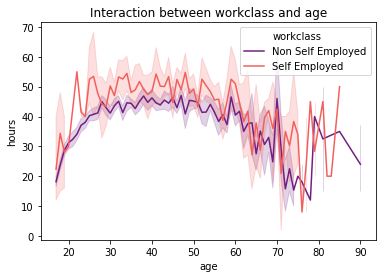

In [237]:
sns.lineplot(x = 'age', y = 'hours', hue = 'workclass', data = income_by_sales, palette = 'magma') 
plt.title('Interaction between workclass and age')
plt.show()

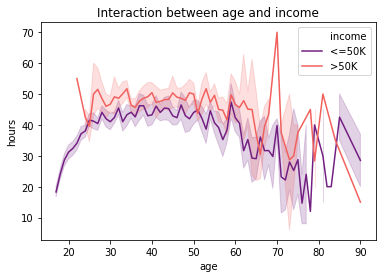

In [238]:
sns.lineplot(x = 'age', y = 'hours', hue = 'income', data = income_by_sales, palette = 'magma') 
plt.title('Interaction between age and income')
plt.show()

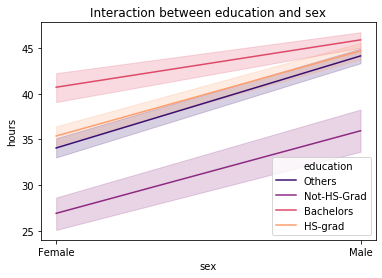

In [239]:
sns.lineplot(x = 'sex', y = 'hours', hue = 'education', data = income_by_sales, palette = 'magma') 
plt.title('Interaction between education and sex')
plt.show()

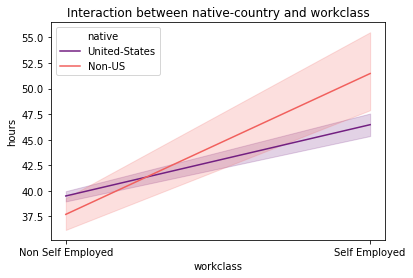

In [240]:
sns.lineplot(x = 'workclass', y = 'hours', hue = 'native', data = income_by_sales, palette = 'magma') 
plt.title('Interaction between native-country and workclass')
plt.show()